In [310]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.calibration import CalibratedClassifierCV


np.random.seed(42)

In [287]:
def get_gender_group(x):
    applicant_gender = x['Gender']
    if applicant_gender == "M":
        gender_group = 1
    else:
        gender_group = 0
    return gender_group


def get_education_group(x):
    applicant_education = x['Education']
    education_map = {"Bachelors": 1, 'Masters': 2, 'PhD': 3}
    return education_map[applicant_education]


def get_age_group(x):
    applicant_age = x['Age']
    if 22 <= applicant_age <= 25:
        age_group = 1
    elif 26 <= applicant_age <= 30:
        age_group = 2
    elif 31 <= applicant_age <= 35:
        age_group = 3
    elif 36 <= applicant_age <= 40:
        age_group = 4
    elif 41 <= applicant_age <= 45:
        age_group = 5
    elif 46 <= applicant_age <= 50:
        age_group = 6
    elif 51 <= applicant_age <= 55:
        age_group = 7
    elif 56 <= applicant_age <= 60:
        age_group = 8
    elif 61 <= applicant_age <= 65:
        age_group = 9
    else:
        return 0
    return age_group


min_age, max_age = 22, 65
min_exp, max_exp = 0, 25
age_group_ranges = {"1": [22, 25], "2": [26, 30], "3": [31, 35], "4": [36, 40], "5": [41, 45], "6": [46, 50],
                    "7": [51, 55], "8": [56, 60], "9": [60, 65]}


def set_experience(age_group):
    if age_group == "1":
        experience = np.random.normal(loc=1, scale=0.5)
    elif age_group == "2":
        experience = np.random.normal(loc=3, scale=1)
    elif age_group == "3":
        experience = np.random.normal(loc=6, scale=2)
    elif age_group == "4":
       experience = np.random.normal(loc=10, scale=2)
    elif age_group == "5":
        experience = np.random.normal(loc=13, scale=3)
    elif age_group == "6":
        experience = np.random.normal(loc=13, scale=1)
    elif age_group == "7":
        experience = np.random.normal(loc=20, scale=3)
    elif age_group == "8":
        experience = np.random.normal(loc=22, scale=3)
    elif age_group == "9":
        experience = np.random.normal(loc=25, scale=3)
    else:
        return 0
    return int(np.clip(experience,min_exp,max_exp))


def set_education(gender: str):
    if gender == 'F':
        education = np.random.choice(['Bachelors', 'Masters', 'PhD'], 1, p=[0.2, 0.4, 0.4])
    else:
        education = np.random.choice(['Bachelors', 'Masters', 'PhD'], 1, p=[0.5, 0.3, 0.2])
    return education.item()


def set_data(gender: str, sample_size: int, probabilities=(0.10, 0.15, 0.20, 0.15, 0.15, 0.15, 0.05, 0.05, 0.00)):
    selected_group = np.random.choice(["1", "2", "3", "4", "5", "6", "7", "8", "9"], sample_size, p=probabilities)
    genders = [gender] * sample_size
    ages = []
    experiences = []
    educations = []
    for x, group in enumerate(selected_group):
        age_range = age_group_ranges[group]
        ages.append(np.random.randint(low=age_range[0], high=age_range[1] + 1))
        educations.append(set_education(gender))
        experiences.append(set_experience(group))
    data_dict = {"Gender": genders, "Age": ages, "Education": educations, "Experience": experiences}
    return data_dict

In [288]:
def generate_data(n_male, n_female):
    female_ages_p = (0.15, 0.30, 0.40, 0.14, 0.01, 0.00, 0.00, 0.00, 0.00)
    male_ages_p = (0.10, 0.15, 0.20, 0.15, 0.15, 0.15, 0.10, 0.0, 0.00)
    females_data = set_data(gender='F', sample_size=n_female, probabilities=female_ages_p)
    males_data = set_data(gender='M', sample_size=n_male, probabilities=male_ages_p)
    females_df = pd.DataFrame.from_dict(females_data)
    males_df = pd.DataFrame.from_dict(males_data)
    applicants_df = pd.concat([females_df, males_df], axis=0, ignore_index=True)
    return applicants_df

In [289]:
def decision(x):
    if x['Experience'] <= 4:
        hired = 0
    if x['Education'] == 'PhD' and x['Experience'] >= 5:
        hired = 1
    elif x['Education'] == 'Masters' and x['Experience'] >= 7:
        hired = 1
    elif x['Education'] == 'Bachelors' and x['Experience'] >= 9:
        hired = 1
    else:
        hired = 0
    return hired

def decision2(df, threshold):
    top_k_experience = df[df['Hired'] == 1]['Experience'].nlargest(threshold)
    df['Hired_next'] = df['Hired']
    df.loc[(df['Hired_next'] == 1) & (~df['Experience'].isin(top_k_experience.index)), 'Hired_next'] = 0
    return df

In [290]:
def encode_df(df):
    gender_map = {"F": [1, 0], "M": [0, 1]}
    education_map = {"Bachelors": [1, 0, 0], 'Masters': [0, 1, 0], 'PhD': [0, 0, 1]}
    encoded_df = df.copy()
    encoded_df['Gender'] = df['Gender'].apply(lambda x: gender_map[x])
    encoded_df['Education'] = df['Education'].apply(lambda x: education_map[x])
    return encoded_df

In [291]:
n_male = 50
n_female = 50
second_filter = False
train_df = generate_data(n_male=n_male, n_female=n_female).sample(frac=1)
train_df['Hired'] = train_df.apply(lambda x: decision(x), axis=1)
if second_filter:
    train_df = decision2(train_df, threshold=20)
    train_df['Decision'] = train_df['Hired_next'].replace({0: 'Rejected', 1: 'Selected'})
train_df['Decision'] = train_df['Hired'].replace({0: 'Rejected', 1: 'Selected'})

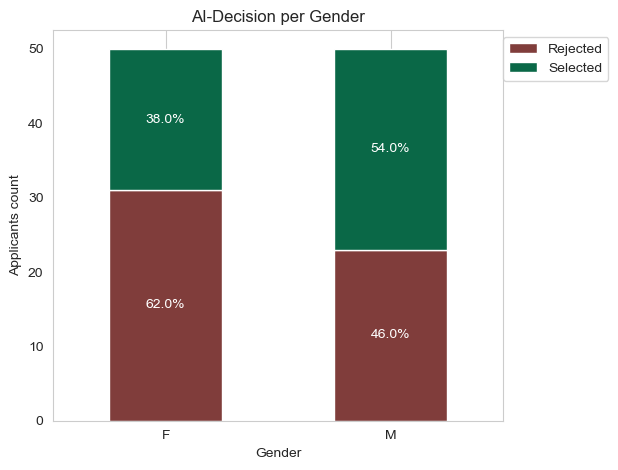

In [292]:
colors = {"Rejected": '#803D3B', "Selected": '#0A6847'}

pivot_table = train_df.pivot_table(index='Gender', columns='Decision', aggfunc='size', fill_value=0)
totals = pivot_table.sum(axis=1)

ax = pivot_table.plot(kind='bar', stacked=True, color=colors)
for i, (idx, row) in enumerate(pivot_table.iterrows()):
    for decision in pivot_table.columns:
        count = row[decision]
        percentage = f'{count / totals[idx] * 100:.1f}%'
        ax.text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')


plt.title("AI-Decision per Gender")
plt.xlabel('Gender')
plt.ylabel('Applicants count')
plt.xticks(rotation=0)
plt.legend(title='', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('figs/noHITL_Gender.png')
plt.show()

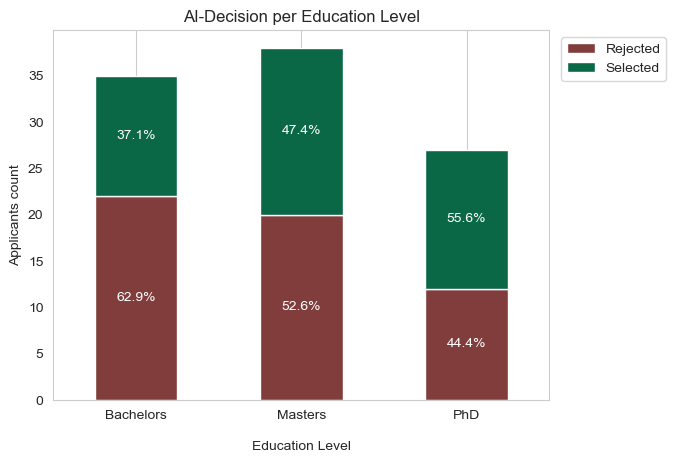

In [293]:
colors = {"Rejected": '#803D3B', "Selected": '#0A6847'}

pivot_table = train_df.pivot_table(index='Education', columns='Decision', aggfunc='size', fill_value=0)
totals = pivot_table.sum(axis=1)

ax = pivot_table.plot(kind='bar', stacked=True, color=colors)
for i, (idx, row) in enumerate(pivot_table.iterrows()):
    for decision in pivot_table.columns:
        count = row[decision]
        percentage = f'{count / totals[idx] * 100:.1f}%'
        ax.text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')



plt.title("AI-Decision per Education Level")
plt.xlabel('\nEducation Level')
plt.ylabel('Applicants count')
plt.xticks(rotation=0)
plt.legend(title='', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.grid(axis='y')
plt.savefig('figs/noHITL_Education.png')
plt.show()

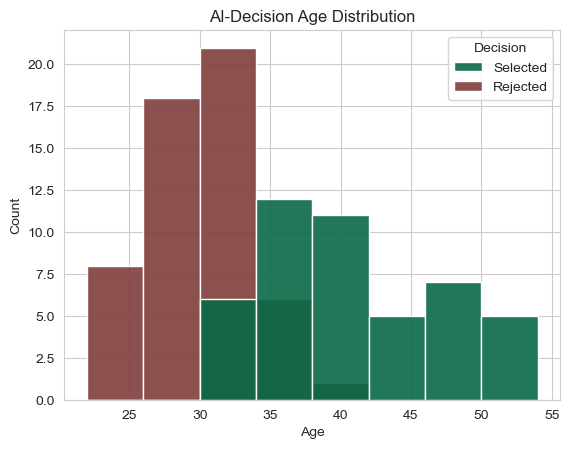

In [294]:
colors = {"Rejected": '#803D3B', "Selected": '#0A6847'}
sns.histplot(data=train_df, x="Age", hue="Decision", multiple="layer", stat="count", bins=8, palette=colors,alpha=0.9)
plt.title("AI-Decision Age Distribution")
plt.savefig('figs/noHITL_AGE.png')

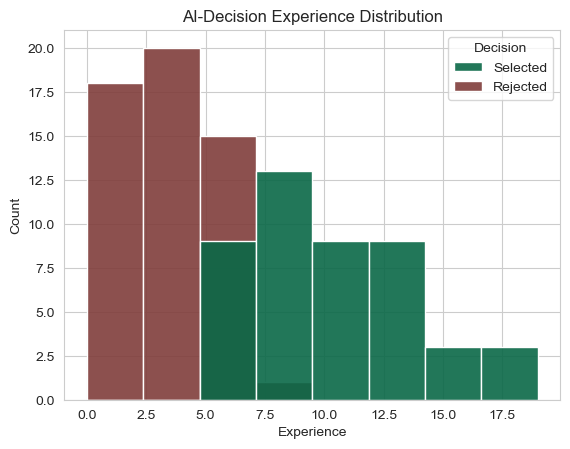

In [295]:
sns.histplot(data=train_df, x="Experience", hue="Decision", multiple="layer", stat="count", bins=8, palette=colors,alpha=0.9)
plt.title("AI-Decision Experience Distribution")
plt.savefig('figs/noHITL_Experience.png')

# Train Model

In [296]:
df = train_df.drop(['Decision'],axis=1).sample(frac=1, random_state=42).reset_index(drop=True)
split_ratio = 0.75
split_index = int(len(df) * split_ratio)
train_set = df.iloc[:split_index]
test_set = df.iloc[split_index:]

In [297]:
train_set

,Gender,Age,Education,Experience,Hired
0,M,27,Bachelors,2,0
1,F,37,Masters,8,1
2,F,26,PhD,0,0
3,F,33,Bachelors,6,0
4,F,22,Bachelors,0,0
...,...,...,...,...,...
70,M,32,Masters,6,0
71,M,23,Bachelors,1,0
72,M,51,PhD,15,1
73,M,48,Bachelors,11,1


In [298]:
encoded_train = pd.get_dummies(train_set, columns=['Education', 'Gender'])
y = encoded_train['Hired']
X = encoded_train.drop(['Hired'], axis=1)
clf = DecisionTreeClassifier().fit(X, y)

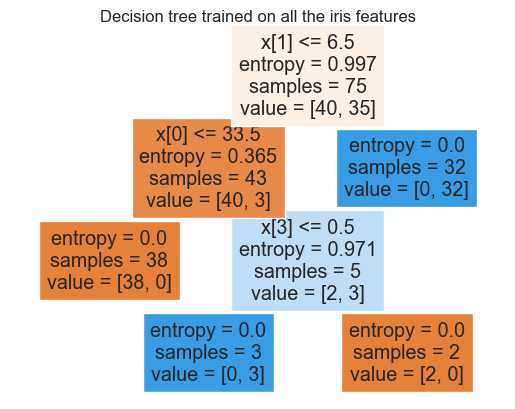

In [299]:
plt.figure()
clf = DecisionTreeClassifier(criterion="entropy").fit(X, y)
plot_tree(clf, filled=True)
plt.title("Decision tree trained on all the iris features")
plt.show()

# HITL

In [302]:
def HITL(x):
    if x['Gender'] == 'M':
        if x['Experience'] <= 5:
            hired = 0
        if x['Education'] == 'PhD' and x['Experience'] >= 5:
            hired = 1
        elif x['Education'] == 'Masters' and x['Experience'] >= 9:
            hired = 1
        elif x['Education'] == 'Bachelors' and x['Experience'] >= 10:
            hired = 1
        else:
            hired = 0
    else:
        if x['Education'] == 'PhD' and x['Experience'] >= 3:
            hired = 1
        elif x['Education'] == 'Masters' and x['Experience'] >= 5:
            hired = 1
        elif x['Education'] == 'Bachelors' and x['Experience'] >= 7:
            hired = 1
        else:
            hired = 0
    return hired

In [304]:
train_df['Hired_HITL'] = train_df.apply(lambda x: HITL(x), axis=1)
train_df['Decision_HITL'] = train_df['Hired_HITL'].replace({0: 'Rejected', 1: 'Selected'})
train_df

,Gender,Age,Education,Experience,Hired,Decision,Hired_HITL,Decision_HITL
96,M,43,Bachelors,15,1,Selected,1,Selected
92,M,28,Bachelors,2,0,Rejected,0,Rejected
48,F,36,Masters,11,1,Selected,1,Selected
14,F,26,PhD,4,0,Rejected,1,Selected
60,M,31,Bachelors,9,1,Selected,0,Rejected
...,...,...,...,...,...,...,...,...
53,M,26,Bachelors,3,0,Rejected,0,Rejected
71,M,49,Masters,13,1,Selected,1,Selected
58,M,28,Masters,2,0,Rejected,0,Rejected
86,M,24,PhD,2,0,Rejected,0,Rejected


# Audit

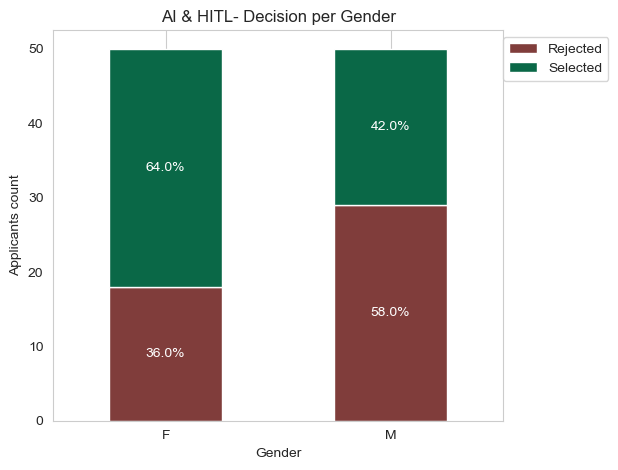

In [305]:
colors = {"Rejected": '#803D3B', "Selected": '#0A6847'}

pivot_table = train_df.pivot_table(index='Gender', columns='Decision_HITL', aggfunc='size', fill_value=0)
totals = pivot_table.sum(axis=1)

ax = pivot_table.plot(kind='bar', stacked=True, color=colors)
for i, (idx, row) in enumerate(pivot_table.iterrows()):
    for decision in pivot_table.columns:
        count = row[decision]
        percentage = f'{count / totals[idx] * 100:.1f}%'
        ax.text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')


plt.title("AI & HITL- Decision per Gender")
plt.xlabel('Gender')
plt.ylabel('Applicants count')
plt.xticks(rotation=0)
plt.legend(title='', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('figs/withHITL_Gender.png')
plt.show()

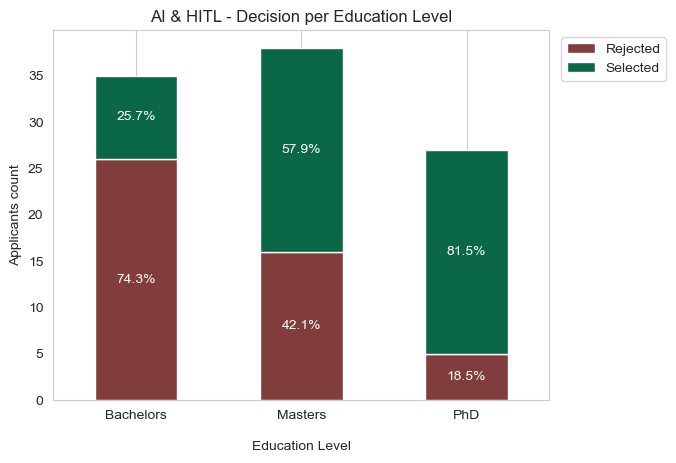

In [306]:
colors = {"Rejected": '#803D3B', "Selected": '#0A6847'}

pivot_table = train_df.pivot_table(index='Education', columns='Decision_HITL', aggfunc='size', fill_value=0)
totals = pivot_table.sum(axis=1)

ax = pivot_table.plot(kind='bar', stacked=True, color=colors)
for i, (idx, row) in enumerate(pivot_table.iterrows()):
    for decision in pivot_table.columns:
        count = row[decision]
        percentage = f'{count / totals[idx] * 100:.1f}%'
        ax.text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')



plt.title("AI & HITL - Decision per Education Level")
plt.xlabel('\nEducation Level')
plt.ylabel('Applicants count')
plt.xticks(rotation=0)
plt.legend(title='', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.grid(axis='y')
plt.savefig('figs/withHITL_Education.png')
plt.show()

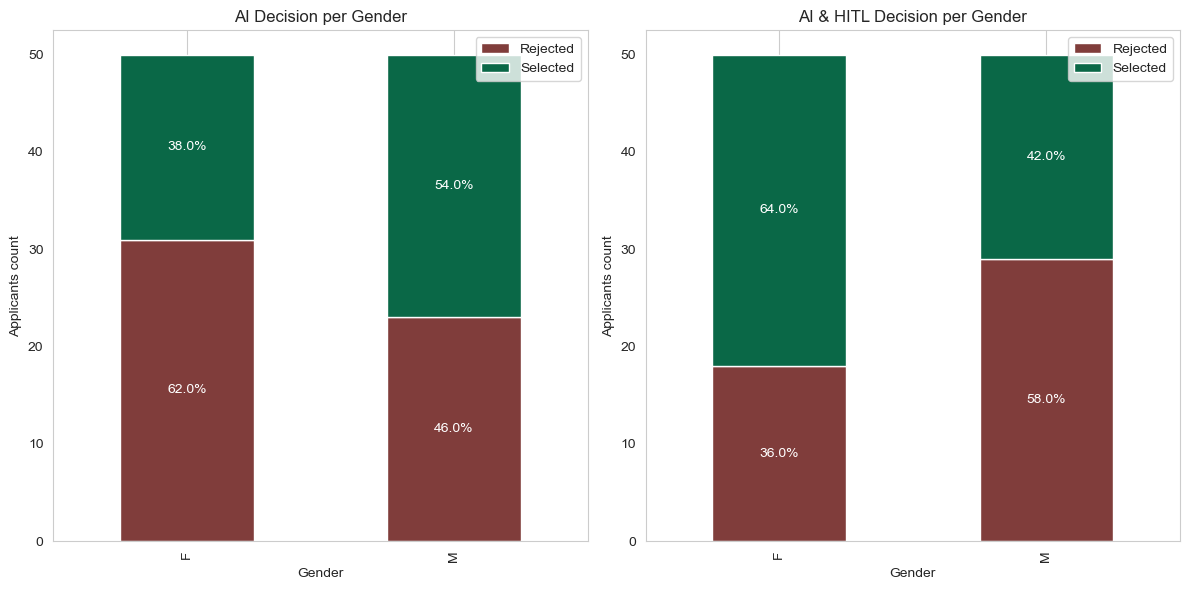

In [307]:
colors = {"Rejected": '#803D3B', "Selected": '#0A6847'}

pivot_table_decision = train_df.pivot_table(index='Gender', columns='Decision', aggfunc='size', fill_value=0)
pivot_table_hitl = train_df.pivot_table(index='Gender', columns='Decision_HITL', aggfunc='size', fill_value=0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1 = pivot_table_decision.plot(kind='bar', stacked=True, color=colors, ax=axes[0])
ax1.set_title("AI Decision per Gender")
ax1.set_xlabel('Gender')
ax1.set_ylabel('Applicants count')
ax1.legend(title='', loc='upper right')
ax1.grid(axis='y')


totals_decision = pivot_table_decision.sum(axis=1)
for i, (idx, row) in enumerate(pivot_table_decision.iterrows()):
    for decision in pivot_table_decision.columns:
        count = row[decision]
        percentage = f'{count / totals_decision[idx] * 100:.1f}%'
        ax1.text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')

ax2 = pivot_table_hitl.plot(kind='bar', stacked=True, color=colors, ax=axes[1])
ax2.set_title("AI & HITL Decision per Gender")
ax2.set_xlabel('Gender')
ax2.set_ylabel('Applicants count')
ax2.legend(title='', loc='upper right')
ax2.grid(axis='y')


totals_hitl = pivot_table_hitl.sum(axis=1)
for i, (idx, row) in enumerate(pivot_table_hitl.iterrows()):
    for decision in pivot_table_hitl.columns:
        count = row[decision]
        percentage = f'{count / totals_hitl[idx] * 100:.1f}%'
        ax2.text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')


plt.tight_layout()
plt.savefig('figs/combined_GENDER_images.png')
plt.show()

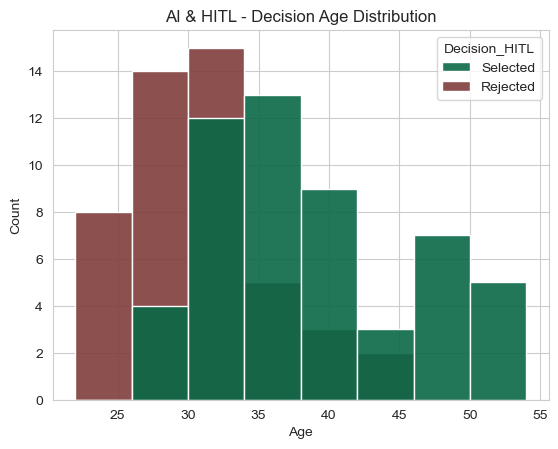

In [308]:
colors = {"Rejected": '#803D3B', "Selected": '#0A6847'}
sns.histplot(data=train_df, x="Age", hue="Decision_HITL", multiple="layer", stat="count", bins=8, palette=colors,alpha=0.9)
plt.title("AI & HITL - Decision Age Distribution")
plt.savefig('figs/withHITL_AGE.png')

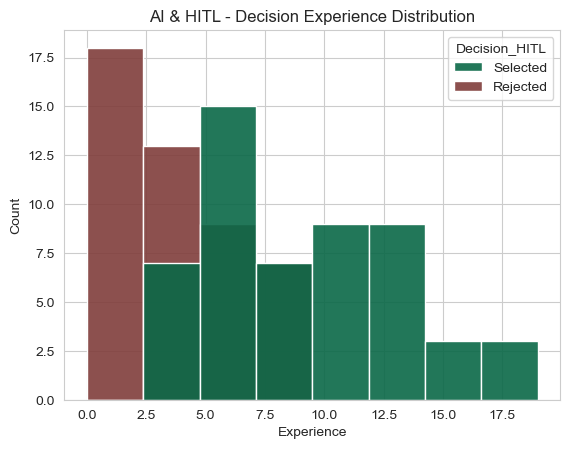

In [309]:
sns.histplot(data=train_df, x="Experience", hue="Decision_HITL", multiple="layer", stat="count", bins=8, palette=colors,alpha=0.9)
plt.title("AI & HITL - Decision Experience Distribution")
plt.savefig('figs/withHITL_Experience.png')

# Model - Dismiss

In [312]:
encoded_train = pd.get_dummies(train_set, columns=['Education', 'Gender'])
y_train = encoded_train['Hired']
X_train = encoded_train.drop(['Hired'], axis=1)
clf = DecisionTreeClassifier().fit(X, y)

base_model = LogisticRegression()
base_model.fit(X_train, y_train)

calibrated_model = CalibratedClassifierCV(base_model, method='sigmoid', cv='prefit')
calibrated_model.fit(X_train, y_train)

X_test = test_set.drop(['Hired'], axis=1)
encoded_test = pd.get_dummies(X_test, columns=['Education', 'Gender'])
pred = calibrated_model.predict_proba(encoded_test)[:,-1]
X_test['Hiring_Probability'] = pred
X_test

,Gender,Age,Education,Experience,Hiring_Probability
75,F,27,Masters,3,0.011314
76,M,36,Bachelors,8,0.857420
77,M,35,Bachelors,3,0.070436
78,M,32,Bachelors,3,0.041636
79,M,39,Bachelors,15,0.999729
80,F,32,PhD,6,0.501243
81,F,33,PhD,3,0.089253
82,M,47,Bachelors,13,0.999672
83,F,33,Masters,5,0.156781
84,M,28,Bachelors,2,0.008875
